# Calculate gaussian std and prototypes using euclidean distance

In [9]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
import numpy as np
import h5py
from os.path import join
import json
current_path = os.getcwd()
sys.path.append(os.path.dirname(current_path))

from os.path import join
from omegaconf import DictConfig, open_dict, OmegaConf
from utils.utils import grab_arg_from_checkpoint, prepend_paths, re_prepend_paths, get_transforms
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:1


In [3]:
# Load checkpoint
result_folder = '/home/siyi/project/mm/result/Dynamic_project/PM40/demo_DynamicTransformer_singleCLS_EU_whole_none_PolyMNIST_DynamicTransformer_singleCLS_0702_174823'
if 'CAD' in result_folder or 'Infarction' in result_folder or 'CelebA' in result_folder:
    eval_metric = 'auc'
else:
    eval_metric = 'acc'
checkpoint_path = join(result_folder, f'downstream/checkpoint_best_{eval_metric}.ckpt')
ckpt = torch.load(checkpoint_path, map_location='cpu')
args = ckpt['hyper_parameters']
args = OmegaConf.create(args)
args['data_base'] = args.data_base_cq
OmegaConf.set_struct(args, False)
args.checkpoint = checkpoint_path
args.data_base = join(args.data_base, args.data_base_postfix)
args = re_prepend_paths(args)
hparams = args
if 'low' not in args.keys():
    args.low = 1.0

In [4]:
import scipy.stats as stats
# folder to store features for each subset
storage_folder = result_folder+'/gaussian'

In [ ]:
# Load dataset
if args.dataset_name == 'PolyMNIST':
    from datasets.PolyMNISTDataset import PolyMNISTDataset
    image_size = grab_arg_from_checkpoint(hparams, 'image_size')
    missing_train = 'missing_train_whole_none'
    train_dataset = PolyMNISTDataset(
        unimodal_datapaths=hparams.DATA_train, data_base=hparams.data_base, missing_path=missing_train, transform=get_transforms(image_size,hparams.target,'train'),
        target_transform=None, low=hparams.low)
elif args.dataset_name == 'MST':
        from datasets.MSTDataset import SVHNMNIST
        missing_train = 'none'
        flags = {'dir_data': hparams.data_base, 'len_sequence': 8, 'data_multiplications': 20}
        flags = OmegaConf.create(flags)
        alphabet_path = join(hparams.data_base, 'alphabet.json')
        with open(alphabet_path) as alphabet_file:
            alphabet = str(''.join(json.load(alphabet_file)))
        train_dataset = SVHNMNIST(flags, alphabet, train='train', missing_path=missing_train, transform=get_transforms(hparams.image_size, hparams.target, 'train'))
        hparams.alphabet = alphabet
elif hparams.dataset_name == 'CelebA':
    from datasets.CelebADataset import CelebaDataset
    missing_train = 'none'
    flags = {'dir_data': hparams.data_base, 'dir_text': hparams.data_base, 'len_sequence': 256, 'random_text_ordering': False, 'random_text_startindex': True}
    flags = OmegaConf.create(flags)
    alphabet_path = join(hparams.data_base, 'alphabet.json')
    with open(alphabet_path) as alphabet_file:
        alphabet = str(''.join(json.load(alphabet_file)))
    train_dataset = CelebaDataset(flags, alphabet, missing_path=missing_train, partition=0, transform=get_transforms(hparams.image_size, hparams.target, 'train'))
    hparams.alphabet = alphabet
elif hparams.dataset_name in set(['DVM', 'CAD', 'Infarction']):
    from datasets.TIPDataset import ImagingAndTabularDataset
    missing_train = 'none'
    train_dataset = ImagingAndTabularDataset(
                hparams.DATA_data_train_eval_imaging, hparams.delete_segmentation, hparams.augmentation_rate, 
                hparams.DATA_data_train_eval_tabular, hparams.DATA_field_lengths_tabular, hparams.eval_one_hot,
                hparams.DATA_labels_train_eval_imaging, hparams.image_size, hparams.live_loading, train=False, target=hparams.target,
                corruption_rate=hparams.corruption_rate, data_base=hparams.data_base, augmentation_speedup=hparams.augmentation_speedup,
                missing_tabular=hparams.missing_tabular, missing_strategy=hparams.missing_strategy, missing_rate=hparams.missing_rate,algorithm_name=hparams.algorithm_name,
                missing_path=missing_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

Using PlyMNIST transforms for train mode
Missing mask data loaded from /bigdata/siyi/data/MoPoE/PolyMNIST/missing_modality/missing_train_whole_none.csv
Missing mask example: [False False False False False]


In [6]:
if args.dataset_name == 'PolyMNIST':
    from models.PolyMNIST.Dynamic.DynamicTransformer import DynamicTransformer
    model = DynamicTransformer(args)
elif args.dataset_name == 'MST':
    from models.MST.Dynamic.DynamicTransformer import DynamicTransformer
    model = DynamicTransformer(args)
elif args.dataset_name == 'CelebA':
    from models.CelebA.Dynamic.DynamicTransformer import DynamicTransformer
    model = DynamicTransformer(args)
elif hparams.dataset_name in set(['DVM', 'CAD', 'Infarction']):
    from models.TIPData.Dynamic.DynamicTransformer import DynamicTransformer
    model = DynamicTransformer(args)
model.load_state_dict(ckpt['state_dict'], strict=True)
model.eval()

DynamicTransformer
Randomly drop 0 modalities
Use distance metric for DynamicTransformer: squared_euclidean


DynamicTransformer(
  (m_encoders): ModuleList(
    (0): UnimodalEncoder(
      (network): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): ReLU()
      )
      (proj_conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): UnimodalEncoder(
      (network): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): ReLU()
      )
      (proj_conv): Sequential(
   

In [7]:
def extract_feature(train_loader, model, mask0):
    feat_list = []
    y_list = []
    y_hat_list = []
    for batch in tqdm(train_loader):
        x, _, y = batch
        for key in x:
            x[key] = x[key].to(device)
        # y = y.to(device)
        mask0 = torch.tensor(mask0).to(device)
        mask = mask0.expand(len(y), -1)
        # print(mask)
        with torch.no_grad():
            y_hat, feat = model.forward_train(x, mask)
        feat_list.append(feat.cpu().numpy())
        y_list.extend(y.cpu().numpy())
        y_hat_list.extend(y_hat.cpu().numpy())
        # break
    feat = np.concatenate(feat_list, axis=0)
    y_list = np.array(y_list)
    y_hat_list = np.array(y_hat_list)
    return feat, y_list, y_hat_list

def calculate_class_prototypes(feat, y, num_classes):
    feat = np.array(feat)
    y = np.array(y)
    prototypes = np.zeros((num_classes, feat.shape[1]))
    prot_dist_std = np.zeros((num_classes))
    t_dist_params = np.zeros((num_classes, 3))
    for i in range(num_classes):
        mask = (y == i)
        feat_i = feat[mask]
        prototype = np.mean(feat_i, axis=0, keepdims=True)
        prototypes[i] = prototype
        # use euclidean distance
        distance = np.linalg.norm(feat_i - prototype, axis=1)
        whole_distance = np.concatenate((-distance, distance), axis=0)
        assert whole_distance[:len(distance)].sum() + whole_distance[len(distance):].sum() == 0
        std = np.std(whole_distance)
        prot_dist_std[i] = std
        # fit t-distribution
        df, loc, scale = stats.t.fit(whole_distance)
        t_dist_params[i] = [df, loc, scale]
    return prototypes, prot_dist_std, t_dist_params, whole_distance

In [ ]:
id2subset = model.id2subset
prototypes_all = []
dist_std_all = []
t_dist_params_all = []
model = model.to(device)
num_classes = hparams.num_classes
print('Number of classes:', num_classes)
for subset in id2subset.items():
    id, mask0 = subset
    print(f'Extracting {id}: {mask0} features')
    feat, y, y_hat = extract_feature(train_loader, model, mask0)
    prototypes, prot_dist_std, t_dist_params, whole_distance = calculate_class_prototypes(feat, y, num_classes)
    print(whole_distance.max(), whole_distance.min())
    prototypes_all.append(prototypes)
    dist_std_all.append(prot_dist_std)
    t_dist_params_all.append(t_dist_params)
    # break
prototypes_all = torch.from_numpy(np.array(prototypes_all))
overall_prototypes = prototypes_all.mean(dim=0)
dist_std_all = torch.from_numpy(np.array(dist_std_all))
t_dist_params_all = torch.from_numpy(np.array(t_dist_params_all))

In [8]:
# store prototypes and std
if not os.path.exists(storage_folder):
    os.makedirs(storage_folder)
subset_gaussian = {
    'prototypes': prototypes_all.float(),
    'overall_prototypes': overall_prototypes.float(),
    'dist_std': dist_std_all.float(),
    't_dist_params': t_dist_params_all.float(),
    'id2subset': id2subset,
    'subset2id': model.subset2id,
}
torch.save(subset_gaussian, os.path.join(storage_folder, 'subset_gaussian_EU.pt'))

In [9]:
subset_prototypes, subset_prot_dist_std, t_dist_params, whole_distance = calculate_class_prototypes(feat, y, num_classes)
print('whole_distance', whole_distance)
print('std: ', subset_prot_dist_std)
print('t_dist_params', t_dist_params)

whole_distance [-1.1121639 -1.3020273 -3.6138434 ...  2.6900978  2.6354725  1.4346585]
std:  [1.36653364 1.72093487]
t_dist_params [[ 3.56880717e+03 -9.40621126e-04  1.36612032e+00]
 [ 8.74412023e+03 -2.26521280e-04  1.71685106e+00]]


Text(0.5, 0, 'Distance')

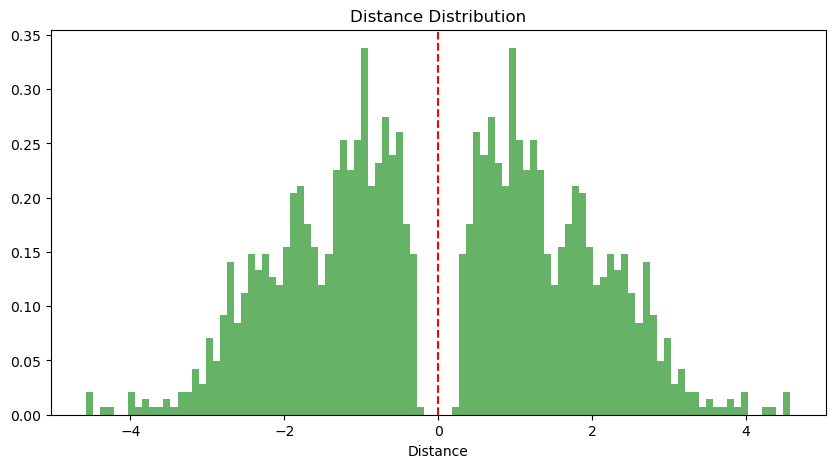

In [10]:
# Plot the similarity distribution
plt.figure(figsize=(10, 5))
plt.hist(whole_distance, bins=100, density=True, alpha=0.6, color='g', label='whole similarity')
plt.axvline(x=0, color='r', linestyle='--', label='0')
plt.title('Distance Distribution')
plt.xlabel('Distance')

In [11]:
# Example: calculate the density of j-th feat
y_hat_tensor = torch.from_numpy(y_hat)
pred = torch.softmax(y_hat_tensor, dim=1).cpu().numpy()
max_prob, max_index = np.max(pred, axis=1), np.argmax(pred, axis=1)
j = 20
label = y[j]
pred_label = max_index[j]
prototype = subset_prototypes[label]
normal_dist = torch.distributions.Normal(0, subset_prot_dist_std[label])
dist = np.linalg.norm(feat[j] - prototype, axis=0)

print('dist', dist)
probability = 2 * (1-normal_dist.cdf(torch.tensor(dist)))
print('probability using y', probability)
print('y', y[j])

# Use the predicted label to calculate the probability
print('y_hat', max(pred[j]), np.argmax(pred[j]), pred[j, y[j]])
prototype = subset_prototypes[pred_label]
normal_dist = torch.distributions.Normal(0, subset_prot_dist_std[pred_label])
dist = np.linalg.norm(feat[j] - prototype, axis=0)
probability = 2 * (1-normal_dist.cdf(torch.tensor(dist)))
print('probability using y_hat', probability)


dist 1.6433212946328568
probability using y tensor(0.3396, dtype=torch.float64)
y 1
y_hat 0.6192602 0 0.38073984
probability using y_hat tensor(0.2161, dtype=torch.float64)
